# (Try to) Extract Gentrification-Relevant Information from public data using a Large Language Model

Apply an LLM to various datasets  to try to extract those that might be indicative of some kind of gentrification.

Data included so far:

  - Historic tweets
  - FourSquare tips

## Libraries

In [1]:
import os
import re

import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
from shapely.geometry import Point
from datetime import datetime

from sklearn.metrics import cohen_kappa_score
from statsmodels.stats.inter_rater import fleiss_kappa


#from kaggle.api.kaggle_api_extended import KaggleApi  # pip install kaggle
from together import Together  # pip install together


# Easier display options for debugging: 

# Set the display width to a larger value
pd.set_option('display.width', 1000)

# Optionally, set the max column width to avoid truncating column data
pd.set_option('display.max_colwidth', None)

# Optionally, set the max number of columns to show all columns
pd.set_option('display.max_columns', None)

# Create a log with the current time
LOG_FILE = os.path.join("logs", datetime.now().strftime("%Y-%m-%d-%H%M%S.log"))
def log(msg):
    with open(LOG_FILE, 'a') as f:
        f.write(msg)



## Function to get gentrification scores from tweets / etc

In [2]:
# Default prompt used in the Twitter part
_system_prompt = """
Analyze the following tweets to determine their relevance to gentrification.
Consider indicators such as mentions of urban development, demographic shifts, displacement concerns, socioeconomic changes, and cultural transformations.
Assign a score from 1 to 5, where 1 means not suggestive of gentrification and 5 means highly suggestive.
Provide your answer strictly in the format ‘1. Score’, ‘2. Score’, etc., without any additional explanation or commentary.
"""

In [3]:
def get_gentrification_scores(batch_tweets, batch_index=0, system_prompt=_system_prompt, log_file=LOG_FILE, max_tokens=200):
    """
    Retrieves gentrification scores for a batch of tweets using the Together AI API.

    Parameters
    ----------
    batch_tweets : pandas.DataFrame
        A DataFrame containing the tweets for the current batch.
        It must include a 'text' column with the tweet content.
    batch_index : int
        An optional starting index of the current batch.
        This is used to align the predicted sentiments with the original DataFrame indices.
    system_prompt : str
        An optional system prompt to be sent to the Together AI API.
        The tweet texts will be appended to this prompt.

    Returns
    -------
    ids : list of int
        A list of DataFrame indices corresponding to each tweet in the batch.
        These indices align with the main DataFrame from which this batch was drawn.
    sentiments : list of str
        A list of predicted gentrification scores for each tweet in the batch.
        Possible values are 1 (not suggestive of gentrification) to 5 (highly suggestive).
    explanations : list of str
        Optional explanations that the LLM returns giving it's reason for the the chosen score
        (these may or may not happen depending on the prompt, and the LLM's mood!)
    """

    # Prepare the list of tweets
    tweet_list = "\n".join([f"{idx + 1}. {tweet}"
                            for idx, tweet in enumerate(batch_tweets.text.values)])

    # Create the system prompt
    system_prompt = f"{system_prompt}\n\n{tweet_list}"
    #print("PROMPT:", system_prompt, "\n\n")

    # Prepare the messages
    messages = [
        {
            "role": "system",
            "content": system_prompt
        }
    ]

    # Call the API using parameters that ChatGPT recommends for this task
    response = client.chat.completions.create(
        model="meta-llama/Llama-3.2-90B-Vision-Instruct-Turbo",
        messages=messages,
        max_tokens=max_tokens,  # max length of output (in case I get the prompt wront and it talks for ages...)
        temperature=0.2,  # lower for more deterministic
        top_p=0.9,  # ??
        top_k=40,  # ??
        repetition_penalty=1,
        stop=["<|eot_id|>", "<|eom_id|>"],
        truncate=130560,  # ??
        stream=False  # Set stream to False to get the full response
    )

    # Extract the assistant's reply and get the IDs and scores
    assistant_reply = response.choices[0].message.content.strip()

    # Useful to have a full log for debugging etc
    log(f"{datetime.now().strftime('%Y-%m-%d-%H%M%S')}\n" \
        f"**MESSAGE**\n{messages}\n" \
        f"**RESPONSE**\n{assistant_reply}\n\n")

    # Parse the IDs and scores (and, if available the explanation for the score)
    ids = []
    scores = []
    explanations = []

    # Regex pattern to extract the line number, score, and optional text from a line
    #pattern = r'^\s*(\d+)\s*\.\s*(\d+)\s*$'
    #pattern = r'^\s*(\d+)\s*\.\s*(\d+)(?:\s+(.*))?$'

    #pattern = r'''
    #    ^\s*            # Start of the line, allowing for leading whitespace
    #    (\d+)           # Group 1: The line number
    #    \s*[.:]\s*      # '.' or ':' with optional whitespace on both sides
    #    (\d+)           # Group 2: The score
    #    (?:\s*(.*))?    # Optional text after the score, with optional leading whitespace
    #    $               # End of the line
    #
    #'''
    pattern = r'''
        ^\s*              # Start of line, allow leading whitespace
        (\d+)             # Capture Group 1: The line number
        \s*[.:]\s*        # A dot or colon with optional whitespace
        (?:Score:\s+)?    # Optionally match "Score:" followed by one or more spaces
        (\d+)             # Capture Group 2: The score (one or more digits)
        (?:\s*(.*))?      # Optional text after the score (Group 3)
        $                 # End of the line
    '''

    # Desipte being told not to, sometimes the reply starts with 'Here are the scores:'.
    # or 'Here are the analyses:'
    # Remove at, and any whitespace at the start or end
    assistant_reply = re.sub(r'^\s*Here are the scores:\s*', '', assistant_reply).strip()
    assistant_reply = re.sub(r'^\s*Here are the analyses:\s*', '', assistant_reply).strip()

    # Analyse the reply line-by-line
    lines = assistant_reply.strip().split('\n')
    error_count = 0  # Return -1 on an error (and count the number of errors at the same time)
    for i, line in enumerate(lines):
        # Ignore lines that are empty once they have been stripped
        line = line.strip()
        if not line:
            continue

        # Try to match the line
        match = re.match(pattern, line, re.VERBOSE)
        if match:
            # Extract the index and score from the match groups
            index = int(match.group(1))
            score = int(match.group(2))
            explanation = match.group(3)
            log(f"{i} {line}\n\t{index},{score},{explanation}")
            # Validate the score range
            if 1 <= score <= 5:
                ids.append(index)
                scores.append(score)
                explanations.append(explanation)
            else:
                msg = f"Warning: Score {score} out of range on line {i}: '{line}'"
                print(msg)
                log(msg)
                error_count += 1
        else:
            msg = f"\n*********************\n" \
                  f"Warning: Invalid format on line {i}: '{line}'.\n" \
                  f"The full response was: \n{assistant_reply}\n" \
                  f"*********************\n"
            print(msg)
            log(msg)
            error_count += 1
            break

        if index-1 >= len(batch_tweets):
            msg = f"Found {index} tweets, but there are more lines. Assuming remaining lines are junk and ignoring them."
            log(f)
            print(f)
            break

    if error_count > 0:
        # There was an error, set scores to -1 and assume tweet IDs from
        # 1 to len(batch_tweets).
        scores = [-1] * len(batch_tweets)
        ids = [x + 1 for x in range(len(batch_tweets))]
        explanations = ["ERROR"] * len(batch_tweets)
        # Do I need to also set the indices as the ids array may not have been populated

    # Compute dataframe indices
    df_ids = [batch_index + int(id) - 1 for id in ids]

    #print("ids:", ids)
    #print("scores:", scores)

    assert len(df_ids) == len(scores), f"Length of ids ({len(df_ids)} does not match length of scores ({len(scores)})."
    return df_ids, scores, explanations

    ## Use regular expressions to extract the scores
    #matches = re.findall(r"(\d+)\.\s*(1|2|3|4|5)", assistant_reply, re.IGNORECASE)

    ## Check that the numbering is correct (optional)
    ## You can add code here to verify the numbering matches the tweets

    ## Compute the actual DataFrame indices
    #ids = [batch_index + int(idx) - 1 for idx, score in matches]
    #scores = [int(score) for idx, score in matches]
    #assert len(ids) == len(scores)

    #return ids, scores


## Open Twitter data

Currently use a historic library of tweets that were downloaded using various APIs by the researchers.

In [4]:
# Read a small sample dataset I created for testing 
#tweets_df = pd.read_csv(os.path.join("..", "data", "uk_tweets", "uk_tweets-2017-02-15.sample.csv"),
#                        quotechar='"',
#                        skipinitialspace=True)

# Read the full dataset, but optionally skip loads of rows to make it smaller
# (in future read the whole thing and then start to filter, e.g. by removing tweets without coordinates or outside the study area)
num_skip = 500  # Read only one in every num_skip rows
tweets_df = pd.read_csv(
    os.path.join("..", "data", "uk_tweets", "uk_tweets-2017-02-15.csv.gz"),
    quotechar='"',
    skipinitialspace=True,
    skiprows=lambda x: x != 0 and x % num_skip != 0  # Skip rows that aren't 0 (need the header) or where they're not a multiple of num_skip
)

In [5]:
print(tweets_df.columns)
tweets_df

Index(['id', 'user-id', 'user-screen_name', 'geo-coordinates-0', 'geo-coordinates-1', 'coordinates-coordinates-0', 'coordinates-coordinates-1', 'place-full_name', 'created_at', 'text', 'Year', 'Month', 'Day', 'Hour', 'Minute', 'Second'], dtype='object')


,id,user-id,user-screen_name,geo-coordinates-0,geo-coordinates-1,coordinates-coordinates-0,coordinates-coordinates-1,place-full_name,created_at,text,Year,Month,Day,Hour,Minute,Second
0,672783702498410496,131108904,owaindaviess,NaN,NaN,NaN,NaN,Tumble_ Wales,Fri Dec 04 14:25:09 +0000 2015,Crack on https://t.co/vTQs6JQJ2G,2015,12,4,14,25,9
1,672784137867104257,1236556939,BruhItsShannon,NaN,NaN,NaN,NaN,Leyland_ England,Fri Dec 04 14:26:52 +0000 2015,I'll slice your fingers off one by one 😊😊😊😊😊😊😊😊😊😊,2015,12,4,14,26,52
2,672784599550844928,152362842,lloydhull,NaN,NaN,NaN,NaN,Hull_ England,Fri Dec 04 14:28:42 +0000 2015,@Carl_Froch I'd love to see you fight GGG. There would only be one person getting knocked out and it wouldn't be you #DrIronJaw,2015,12,4,14,28,42
3,672784968440020992,269913251,ReInventionRoom,NaN,NaN,NaN,NaN,Stirling_ Scotland,Fri Dec 04 14:30:10 +0000 2015,Remember I am in @sainsburys #stirling as your personal #stylist tom 10-2 @SainsburysNews @manager_marc @Mrstirling01 #style #lookgood,2015,12,4,14,30,10
4,672785372758327300,371737109,Poppy_rich,NaN,NaN,NaN,NaN,South West_ England,Fri Dec 04 14:31:47 +0000 2015,@laulauutyler old town or town thoughhhhhh,2015,12,4,14,31,47
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209481,831477922313691136,49743959,CharlCunliffe,NaN,NaN,NaN,NaN,Manchester_ England,Tue Feb 14 12:19:19 +0000 2017,Sat in the library drowning in philosophy with an absolute fucking banger of a hangover_ happy Valo's to me 😂😘,2017,2,14,12,19,19
209482,831478423621136384,286669466,ThatGarateyjc,NaN,NaN,NaN,NaN,Stevenage_ East,Tue Feb 14 12:21:18 +0000 2017,Would you not fancy @Everton to pinch a @EuropaLeague place? https://t.co/zVJnAITjRe,2017,2,14,12,21,18
209483,831478900685406209,830959383974649857,nommm_1,NaN,NaN,NaN,NaN,High Wycombe_ England,Tue Feb 14 12:23:12 +0000 2017,https://t.co/qa2ojYbrDb,2017,2,14,12,23,12
209484,831479419902496768,1935269935,Wellybix,NaN,NaN,NaN,NaN,Romaldkirk_ England,Tue Feb 14 12:25:16 +0000 2017,Yes.... It's freezing here today._Welly is having a duvet day 😴😴 https://t.co/Rq71KpAyUD,2017,2,14,12,25,16


Select some Tweets from near Glasgow for the Urban Analytics presentation

In [6]:
# Rough bounding box around Glasgow 
lat_min = 55.7   # Slightly south of Glasgow
lat_max = 56.0   # Slightly north of Glasgow
lon_min = -4.5   # Slightly west of Glasgow
lon_max = -4.0   # Slightly east of Glasgow

def shrink_bounding_box( scale_factor):
    global lat_min, lat_max, lon_min, lon_max
    lat_center = (lat_min + lat_max) / 2.0
    lon_center = (lon_min + lon_max) / 2.0

    # Calculate half of the original span for latitude and longitude
    lat_half_span = (lat_max - lat_min) / 2.0
    lon_half_span = (lon_max - lon_min) / 2.0

    # Apply the scale factor to the half spans
    lat_half_span *= scale_factor
    lon_half_span *= scale_factor

    # Calculate the new bounding box coordinates
    lat_min = lat_center - lat_half_span
    lat_max = lat_center + lat_half_span
    lon_min = lon_center - lon_half_span
    lon_max = lon_center + lon_half_span

shrink_bounding_box(0.4)

# Ignore tweets without coordinates
tweets_df_clean = tweets_df.dropna(subset=['geo-coordinates-0', 'geo-coordinates-1']).copy()

# Ensure that latitude and longitude are numeric
tweets_df_clean['geo-coordinates-0'] = pd.to_numeric(tweets_df_clean['geo-coordinates-0'])
tweets_df_clean['geo-coordinates-1'] = pd.to_numeric(tweets_df_clean['geo-coordinates-1'])

# Extract glasgow
gla_df = tweets_df_clean.loc[
    (tweets_df_clean['geo-coordinates-0'] >= lat_min) &
    (tweets_df_clean['geo-coordinates-0'] <= lat_max) &
    (tweets_df_clean['geo-coordinates-1'] >= lon_min) &
    (tweets_df_clean['geo-coordinates-1'] <= lon_max),:
].copy()

# Make a gdf
gla_df['geometry'] = gla_df.apply(
    lambda row: Point(row['geo-coordinates-1'], row['geo-coordinates-0']), axis=1
)
gla_gdf = gpd.GeoDataFrame(gla_df, geometry='geometry', crs='EPSG:4326')  

# Reproject to Web Mercator for Plotting
gla_gdf = gla_gdf.to_crs(epsg=3857)
print(f"Found {len(gla_gdf)} tweets near Glasgow")
gla_gdf


Found 200 tweets near Glasgow


,id,user-id,user-screen_name,geo-coordinates-0,geo-coordinates-1,coordinates-coordinates-0,coordinates-coordinates-1,place-full_name,created_at,text,Year,Month,Day,Hour,Minute,Second,geometry
916,674639162843127808,624771315,GAMEGlasgow,55.859158,-4.257131,-4.257131,55.859158,Glasgow_ Scotland,Wed Dec 09 17:18:05 +0000 2015,New SHAREfactory update adds slow motion_ time lapse_ more https://t.co/nkzB7HZhKa https://t.co/ebEsq7j6wE,2015,12,9,17,18,5,POINT (-473901.677 7530428.965)
2202,675258647941881856,583791139,karen73984451,55.817875,-4.201626,-4.201626,55.817875,Cambuslang_ Scotland,Fri Dec 11 10:19:42 +0000 2015,#12DamesOfChristmas #Super Cutie Alert 😍😍😍💗💗💗Lucy is a fab friendly lass needing a loving home #FFH @NWDogRescue https://t.co/sbr7bo7aYR,2015,12,11,10,19,42,POINT (-467722.877 7522244.746)
3042,675669260660789248,498653180,WarriorWomanFIT,55.890715,-4.233154,-4.233154,55.890715,Glasgow_ Scotland,Sat Dec 12 13:31:19 +0000 2015,So many exciting things and we get this beauty on Christmas Day #spacegeek #astronomy #moon #universe #WWP https://t.co/HlrrvxDrAu,2015,12,12,13,31,19,POINT (-471232.54 7536690.743)
3177,675715526388248576,19708944,spizzenergi,55.859262,-4.258055,-4.258055,55.859262,Glasgow_ Scotland,Sat Dec 12 16:35:10 +0000 2015,#Glasgow #glasgowcentralstation #gigtonight with #therezillos #spizzenergi #punkrockoriginal… https://t.co/4BQSA9i8OS,2015,12,12,16,35,10,POINT (-474004.479 7530449.558)
4334,676145336503689218,211706186,nicolacairns,55.839722,-4.234167,-4.234167,55.839722,Glasgow_ Scotland,Sun Dec 13 21:03:05 +0000 2015,My Christmas tree ☺️🎄🎅🏼🎁 #Christmas #Tree #Festive #Home #Glasgow @ Oatlands_ Glasgow https://t.co/qQGvdb5yHW,2015,12,13,21,3,5,POINT (-471345.278 7526574.823)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202881,827255866818572296,16199886,keith_wilson,55.878160,-4.273699,-4.273699,55.878160,Glasgow_ Scotland,Thu Feb 02 20:42:22 +0000 2017,@stephen_wigmore Such unbridled optimism.,2017,2,2,20,42,22,POINT (-475746.018 7534198.971)
203806,827869832863416320,331163590,Sideshow_Casey,55.816700,-4.183330,-4.183330,55.816700,Cambuslang_ Scotland,Sat Feb 04 13:22:03 +0000 2017,#favouriteplace #puppyunderbed #wontcomeout #bully #bulldog #bulldogdays @ Cambuslang https://t.co/guGaGFg1ol,2017,2,4,13,22,3,POINT (-465686.165 7522012.012)
205413,828762829628989440,377685873,celticCK,55.858000,-4.259000,-4.259000,55.858000,Glasgow_ Scotland,Tue Feb 07 00:30:30 +0000 2017,Embracing every second - I'm the luckiest man alive. Thanks again for your ongoing messages of… https://t.co/vkXpruGn9J,2017,2,7,0,30,30,POINT (-474109.711 7530199.25)
207176,830008382916550656,103652767,TPTMerch,55.865553,-4.264364,-4.264364,55.865553,Glasgow_ Scotland,Fri Feb 10 10:59:53 +0000 2017,Disco load out was a bit hairy! #thepineapplethief #yourwilderness @ Abc O2 Academy Glasgow https://t.co/7p2nyXOOEV,2017,2,10,10,59,53,POINT (-474706.8 7531697.411)


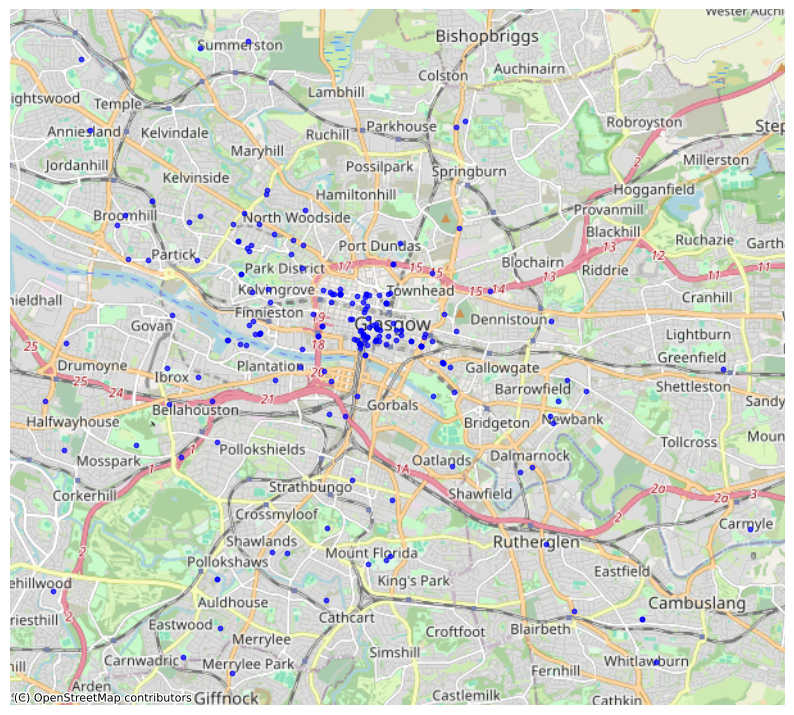

In [7]:
# Plot with a basemap
fig, ax = plt.subplots(figsize=(10, 10))
gla_gdf.plot(ax=ax, marker='o', color='blue', markersize=10, alpha=0.7)
#ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLite)
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
ax.set_axis_off()  # Remove axis for cleaner look
plt.show()

## Use the Together.AI API to batch classify the Tweets as how likely they are to be related to gentrification.

A function that takes a batch of tweets and uses the Together API to classify them. The `_system_prompt` variable contains the prompt that will be sent to the API; individual tweets are appended to this.

The LLM requires some parameter values. Here are the settings that chatGPT recommended (with defaults, that I decided not to use, in brackets)

1.	max_tokens:
	-	Recommendation: 50 (200)
	-	Explanation: Since you’re expecting short responses like '1. Score', a small max_tokens value ensures concise outputs without unnecessary verbosity.
	-    _(I actually choose a larger value because the prompt has been designed to get the LLM to stop long before max_tokens is reached and this way it is hopefully less likely to break if we increase the batch size.
2.	temperature:
	-	Recommendation: 0.2 (0.7)
	-	Explanation: A lower temperature makes the model’s output more deterministic, which is ideal for scoring tasks where consistency is important.
3.	top_p:
	-	Recommendation: 0.9 (0.7)
	-	Explanation: This value balances the randomness and coherence of the output by considering tokens with a cumulative probability up to 90%.
4.	top_k:
	-	Recommendation: 40 (50)
	-	Explanation: Limits the model to consider the top 40 probable next tokens, which helps in generating relevant responses.
5.	repetition_penalty:
	-	Recommendation: 1.1 (1)
	-	Explanation: Slightly penalizes repeated tokens to prevent the model from producing redundant information.

**Note**: The cell below needs updating now that the `get_gentrification_scores` fuction returns the prediction as well as it's score (used later). This means the twitter LLM prompt may need updating too (or maybe not if the regex that parses the LLM output is flexible enough) but I can't be bothered to go back and fix this as this work is redundant now anyway (moving on from this twitter test).

In [8]:
# Get the API key from a file
with open('together.ai_key.txt', 'r') as f:
    api_key = f.readline().strip()

client = Together(api_key=api_key)

# List of tweets to classify (can sample if I want to)
#df = tweets_df.sample(100).copy()
df = gla_gdf.copy()

print(f"Will query the LM for {len(df)} tweets")

assert len(df) < 500, "Too many tweets to process in one go. Please reduce the number of tweets."

# Ensure the index is consecutive and ascending
df = df.reset_index(drop=True)
# To store the results
df['gentrification_prediction'] = None

# Batch processing
batch_size = 20
for i in range(0, len(df), batch_size):
    # Get the batch of tweets
    batch_tweets = df.loc[i:i + batch_size - 1, :]

    # Get sentiments using the function
    print(f"Submitting batch {i//len(batch_tweets)+1} of {len(df)//len(batch_tweets)}...")

    ids, sentiments = get_gentrification_scores(batch_tweets, batch_index=i)

    #for idx, score in zip(ids, sentiments):
    #    print(f"\t{idx}: {score}")

    # Update the DataFrame with the predictions
    df.loc[ids, 'gentrification_prediction'] = sentiments

print("Finished")

Will query the LM for 200 tweets
Submitting batch 1 of 10...


ValueError: too many values to unpack (expected 2)

See how well that worked

In [8]:
df.loc[:,['text', 'gentrification_prediction']]

,text,gentrification_prediction
0,New SHAREfactory update adds slow motion_ time lapse_ more https://t.co/nkzB7HZhKa https://t.co/ebEsq7j6wE,1
1,#12DamesOfChristmas #Super Cutie Alert 😍😍😍💗💗💗Lucy is a fab friendly lass needing a loving home #FFH @NWDogRescue https://t.co/sbr7bo7aYR,1
2,So many exciting things and we get this beauty on Christmas Day #spacegeek #astronomy #moon #universe #WWP https://t.co/HlrrvxDrAu,1
3,#Glasgow #glasgowcentralstation #gigtonight with #therezillos #spizzenergi #punkrockoriginal… https://t.co/4BQSA9i8OS,1
4,My Christmas tree ☺️🎄🎅🏼🎁 #Christmas #Tree #Festive #Home #Glasgow @ Oatlands_ Glasgow https://t.co/qQGvdb5yHW,1
...,...,...
195,@stephen_wigmore Such unbridled optimism.,1
196,#favouriteplace #puppyunderbed #wontcomeout #bully #bulldog #bulldogdays @ Cambuslang https://t.co/guGaGFg1ol,1
197,Embracing every second - I'm the luckiest man alive. Thanks again for your ongoing messages of… https://t.co/vkXpruGn9J,1
198,Disco load out was a bit hairy! #thepineapplethief #yourwilderness @ Abc O2 Academy Glasgow https://t.co/7p2nyXOOEV,1


Plot to have a look at the gentrification prediction scores

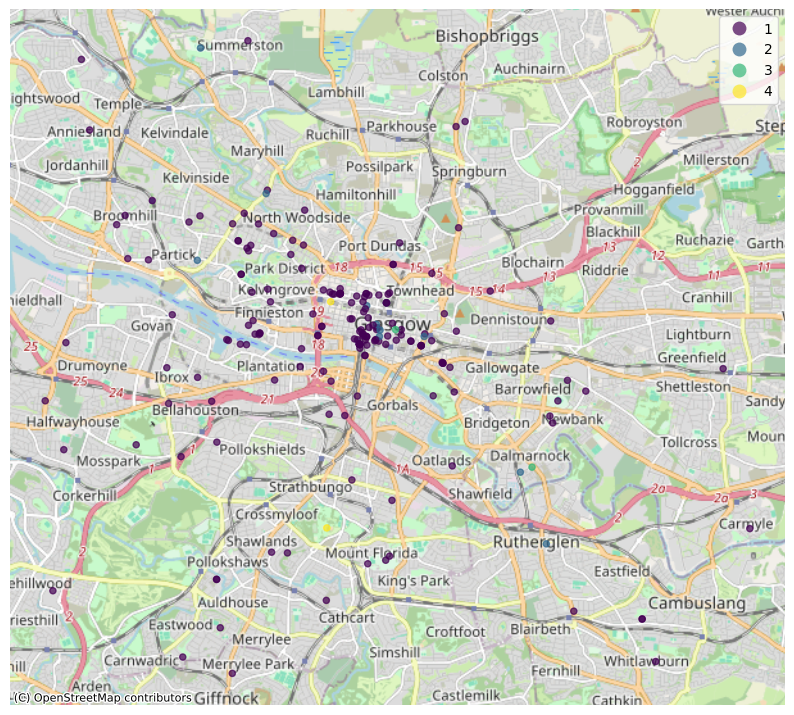

In [9]:
# Plot with a basemap
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the GeoDataFrame, coloring by 'gentrification_prediction'
df.plot(
    ax=ax,
    marker='o',
    column='gentrification_prediction',
    cmap='viridis',  # You can choose a different colormap if you prefer
    markersize=20,
    alpha=0.7,
    legend=True,  # Add a legend to show the color scale
    #legend_kwds={'title': "Gentrification Prediction", 'orientation': "vertical"}
    
)

# Add basemap
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

# Remove axis for cleaner look
ax.set_axis_off()

# Display the plot
plt.show()

Interactive map

In [10]:
# Interactive plot using GeoPandas' explore()
m = df.explore(
    column='gentrification_prediction',
    cmap='viridis',
    marker_type='circle_marker',  # Use circle markers
    marker_kwds={'radius': 10, 'fill': True},
    tooltip=['gentrification_prediction'],  # Add tooltips
    legend=True,  # Show legend
    tiles='OpenStreetMap'  # Add a basemap
)
m.save('glasgow_tweet_map.html')
m

KeyboardInterrupt: 

## FourSquare Data

Dingqi YANG's has made some [Foursquare data](https://sites.google.com/site/yangdingqi/home/foursquare-dataset) avaiable. In particular, the 'NYC Restaurant Rich Dataset (Check-ins, Tips, Tags)' is potentially useful as it has Tips, which are text. I have downloaded this (dataset_ubicomp2013.zip) and extracted it to [dataset_ubicomp2013](./dataset_ubicomp2013).


In [11]:
foursquare = pd.read_csv(
    os.path.join('dataset_ubicomp2013', 'dataset_ubicomp2013_tips.txt'),
    encoding='latin1', sep='\t', names=["userid", "venueid", "text"])

foursquare

,userid,venueid,text
0,24436,15,"make your own sandwich: tuna salad on country white bread, cheddar, lettuce, tomato, cucumber, mayo. yuuuum."
1,8550,20,"The calamari as an appetizer and the quail. Pretty good, if a bit rich. The berry and creme desert thing was really, really good!"
2,1537,20,Be careful with the napkins on your pants. They leave remnants behind. As in lint.
3,59283,20,"try the steak frites, it's the best - believe me"
4,713,20,go visit google across the street. see the big coffee robot
...,...,...,...
10372,2677,2358357,Way too crowded due to the construction at 7th & Fig .. not my favorite
10373,48037,2376156,Not for the faint of heart
10374,231830,2376156,It's goin down Tonight on The Stage (Open Mic for Singers) w\/Live Band hosted by KeShay at NKC 1408 Webster St\/Oakland @9pm NO COVER CHARGE! See You There!
10375,22278,2422200,"In 2011, 60% of the 25,000 orange, red and white light bulbs will be LED. The conversion to LED will be complete by 2013 and will save Texas Tech an estimated 80% on electricity costs."


How long are these texts? (Want to get an idea if they are comparible to tweets)

<Axes: >

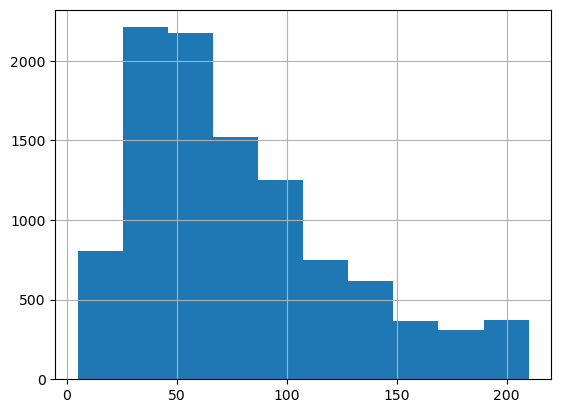

In [12]:
foursquare.text.str.len().hist()

They're simililar. Fine.

Try a slightly different and more specific prompt than with the Twitter data.

In [13]:
# This prompt asks for no explanation
foursquare_prompt_concise = """
You are an expert in urban studies with a deep understanding of gentrification and how it is discussed in public discourse. I will provide you with a tweet, and your task is to analyze its text and determine the extent to which it suggests that the neighborhood or area referenced is experiencing gentrification. Specifically:

Read the tweet closely and identify any words, phrases, or implications that might indicate signs of gentrification, such as mentions of new luxury developments, rising rents, displacement of long-time residents, upscale amenities (e.g., artisanal coffee shops, craft breweries), changing demographics, or neighborhood ‘revitalization.’

Consider both explicit and implicit cues. Explicit cues directly mention new businesses or rising property values, while implicit cues might reflect subtle neighborhood changes.

Assign a score from 1 to 5, where 1 means not suggestive of gentrification and 5 means highly suggestive.

Provide your answer strictly in the format ‘1. Score’, ‘2. Score’, '3. Score', etc., without any additional explanation or commentary.
"""

# This prompt asks explicitly for an explanation (note may need to make sure that 'max_tokens' in the call to the API is sufficiently large

foursquare_prompt_explanatory = """
You are an expert in urban studies with a deep understanding of gentrification and how it is discussed in public discourse. I will provide you with a tweet, and your task is to analyze its text and determine the extent to which it suggests that the neighborhood or area referenced is experiencing gentrification. Specifically:

Read the tweet closely and identify any words, phrases, or implications that might indicate signs of gentrification, such as mentions of new luxury developments, rising rents, displacement of long-time residents, upscale amenities (e.g., artisanal coffee shops, craft breweries), changing demographics, or neighborhood ‘revitalization.’

Consider both explicit and implicit cues. Explicit cues directly mention new businesses or rising property values, while implicit cues might reflect subtle neighborhood changes.

Assign a score from 1 to 5, where 1 means not suggestive of gentrification and 5 means highly suggestive.

Explain your reasoning in 1-2 sentences, referencing the specific words or phrases in the tweet that led you to your conclusion.

Provide your answer strictly in the format ‘1. Score. Reasoning.’, ‘2. Score. Reasoning’, '3. Score. Reasoning', etc., without any additional explanation or commentary.
"""

# The propmpt to use
foursquare_prompt = foursquare_prompt_explanatory

In [14]:
# Get the API key from a file
with open('together.ai_key.txt', 'r') as f:
    api_key = f.readline().strip()

client = Together(api_key=api_key)

# List of tweets to classify (can sample if I want to)
#df = tweets_df.sample(100).copy()
df = foursquare.sample(200)

print(f"Will query the LM for {len(df)} tweets")

assert len(df) < 500, "Too many tweets to process in one go. Please reduce the number of tweets."

# Ensure the index is consecutive and ascending
df = df.reset_index(drop=True)
# To store the results
df['gentrification_prediction'] = None
df['explanation'] = None

# Batch processing
batch_size = 20
for i in range(0, len(df), batch_size):
    # Get the batch of tweets
    batch_tweets = df.loc[i:i + batch_size - 1, :]

    # Get sentiments using the function
    print(f"Submitting batch {i // len(batch_tweets) + 1} of {len(df) // len(batch_tweets)}...")

    ids, sentiments, explanations = (
        get_gentrification_scores(batch_tweets, batch_index=i, system_prompt=foursquare_prompt, max_tokens = 1500))

    #for idx, score in zip(ids, sentiments):
    #    print(f"\t{idx}: {score}")

    # Update the DataFrame with the predictions
    df.loc[ids, 'gentrification_prediction'] = sentiments
    df.loc[ids, 'explanation'] = explanations

print("Finished")

Will query the LM for 200 tweets
Submitting batch 1 of 10...


KeyboardInterrupt: 

Next
 - [X] Read through all of the above output and assess how well it is capturing gentrification-related message
   - _Actually the data do look like you could draw some conclusions about gentrification from them, and the results look quite promising. Possible drawback is that the fact that people are tipping a place on Foursquare may mean it has already been gentrified._
 - [X] Run the same tweets trough >1 times to see how variable the results are. Also try shuffling the batches and/or batch sizes

 - If it's OK, apply to a new dataset (AirBnB in theUK?). Could start to do spatial analysis of foursquare outputs but doubt there's much point.

Thoughts about the process so far
 - The LLM is probabilistic and seems quite sporadic in how it returns information. Mostly seems to be working OK but it's fragile. My regex that parses the output is fairly robust but and small changes to the prompt will probably still lead to output that it cannot recognise. (I think someone said asking it for JSON output can help.
 - Could consider using another LLM to extract the score and explanation from the first one!


## Calculate LLM Variability

See how much the results vary as when the LLM is asked to score them repeatedly, and if we change the batch size etc.

In [15]:
# Cache the sample used previously (or load if if it has already been cached)
cache_file = 'foursquare_experiment_cache.pickle'
if os.path.exists(cache_file):
    df = pd.read_pickle(cache_file)
else:
    df.to_pickle(cache_file)

df

,userid,venueid,text,gentrification_prediction,explanation
0,82569,20006,Village Voice is excited to have Max at the 2012 ChoiceEats food fest! Full list of restaurants here: http:\/\/ow.ly\/8QjDQ,1,". Score. Reasoning. No indication of gentrification, as the tweet only mentions a food festival with no reference to neighborhood changes."
1,132,955,The waitresses wear hoodies. Ummm. Weak.,1,". Score. Reasoning. No indication of gentrification, as the tweet only expresses a negative opinion about the waitresses' attire."
2,69093,4449,Go for happy hour with JC behind the bar!,1,". Score. Reasoning. No indication of gentrification, as the tweet only mentions a happy hour promotion."
3,258445,7002,Lovely French bistro! Have brunch on the patio! You get a delicious basket of pastries. Great cappucinos & the eggs Benny was delish. Make sure you get the homefries!,2,". Score. Reasoning. The mention of a ""lovely French bistro"" and ""delicious basket of pastries"" could suggest a upscale establishment, but there is no clear indication of gentrification."
4,42404,18222,Cereal Milk Shake. Compost Cookie. Mmm.,1,". Score. Reasoning. No indication of gentrification, as the tweet only mentions specific menu items."
...,...,...,...,...,...
195,50489,16983,Delicious pasta and amazing desserts. The decor is simple and chic. (4 of 4 petals via Fondu),2,". Reasoning: The mention of ""simple and chic"" decor might suggest a trendy establishment, but it's not a strong indication of gentrification."
196,33330,151956,Split a plate w\/ someone the portions are too much.,1,. Reasoning: This tweet is a review of the food portions and does not contain any language that suggests gentrification.
197,28979,33444,The French fries are delicious!,1,. Reasoning: This tweet is a review of the food and does not mention anything related to gentrification.
198,30998,135754,Try one of the traditional Little Italy dishes inspired by authentic Italian-American Cuisines across the nation!,1,. Reasoning: This tweet is a review of the food and does not contain any language that suggests gentrification.


Lets re-run the LLM prediction 10 times, adding new columns on each time. (see the chunk above where I do this for the first time for code comments, I'v stripped most of them out of this chunk).

In [16]:
N = 10  # Number of times to redo the prediction

# Column names for the experiments
score_columns = [f"gentrification_prediction{i}" for i in range(N)]
explanation_columns = [f"explanation{i}" for i in range(N)]

# (remember we have one already though)
df = df.rename(columns = {
    "gentrification_prediction" : "gentrification_prediction0",
    "explanation": "explanation0"
})

# Set up the client again, incase the cell where this was done originally hasn't been run
with open('together.ai_key.txt', 'r') as f:
    api_key = f.readline().strip()
client = Together(api_key=api_key)
print(f"Will query the LM for {len(df)} tweets")
assert len(df) < 500, "Too many tweets to process in one go. Please reduce the number of tweets."

# Ensure the index is consecutive and ascending
df = df.reset_index(drop=True)

batch_size = 20
for n in range(1, N):  # Count from 1 as we already have a column0
    # To store the results
    df[score_columns[n]] = None
    df[explanation_columns[n]] = None

    for i in range(0, len(df), batch_size):
        batch_tweets = df.loc[i:i + batch_size - 1, :]
        print(f"{n}/{N} Submitting batch {i // len(batch_tweets) + 1} of {len(df) // len(batch_tweets)}...")

        ids, sentiments, explanations = (
            get_gentrification_scores(batch_tweets, batch_index=i, system_prompt=foursquare_prompt, max_tokens = 1500))

        df.loc[ids, score_columns[n]] = sentiments
        df.loc[ids, explanation_columns[n]] = explanations

print("Finished")

Will query the LM for 200 tweets
1/10 Submitting batch 1 of 10...


KeyboardInterrupt: 

Cache so we don't need to re-call the LLM and add a few columns that are useful later

In [17]:
cache_file = 'foursquare_experiment_cache-after_runningLLM.pickle'
if os.path.exists(cache_file):
    df = pd.read_pickle(cache_file)
else:
    df.to_pickle(cache_file)

# The number of times a prediction failed for each row
df['failed_predictions'] = (df[score_columns] == -1).sum(axis=1)

df

,userid,venueid,text,gentrification_prediction0,explanation0,gentrification_prediction1,explanation1,gentrification_prediction2,explanation2,gentrification_prediction3,explanation3,gentrification_prediction4,explanation4,gentrification_prediction5,explanation5,gentrification_prediction6,explanation6,gentrification_prediction7,explanation7,gentrification_prediction8,explanation8,gentrification_prediction9,explanation9,failed_predictions
0,82569,20006,Village Voice is excited to have Max at the 2012 ChoiceEats food fest! Full list of restaurants here: http:\/\/ow.ly\/8QjDQ,1,". Score. Reasoning. No indication of gentrification, as the tweet only mentions a food festival with no reference to neighborhood changes.",-1,ERROR,1,". Score. Reasoning: The tweet only mentions a food festival and a list of restaurants, with no indication of gentrification.",1,". Reasoning: The tweet only mentions a food festival and a list of restaurants, without any indication of gentrification.",1,". Reasoning: The tweet only mentions a food festival and a list of restaurants, with no indication of gentrification.",1,". Reasoning: The tweet only mentions a food festival and a list of restaurants, with no indication of gentrification.",1,. Not suggestive of gentrification. The tweet is a straightforward announcement about a food festival with no hints of neighborhood change.,1,. Not suggestive of gentrification. The tweet simply promotes a food festival and lists participating restaurants without any indication of neighborhood change.,1,". Score. Reasoning. The tweet only mentions a food festival and a list of restaurants, with no indication of gentrification.",1,". Score. Reasoning. No indication of gentrification, as the tweet only mentions a food festival with no reference to neighborhood changes.",1
1,132,955,The waitresses wear hoodies. Ummm. Weak.,1,". Score. Reasoning. No indication of gentrification, as the tweet only expresses a negative opinion about the waitresses' attire.",-1,ERROR,1,". Score. Reasoning: The tweet is a negative comment about the waitresses' attire, with no relevance to gentrification.",1,". Reasoning: The tweet is a criticism of the waitresses' attire, with no reference to neighborhood changes.",1,". Reasoning: The tweet is a negative comment about the waitresses' attire, with no relevance to gentrification.",1,". Reasoning: The tweet is a negative comment about the waitresses' attire, with no relevance to gentrification.",1,". Not suggestive of gentrification. The tweet is a negative comment about a waitress's attire, with no relevance to gentrification.",1,". Not suggestive of gentrification. The tweet expresses a negative opinion about the waitresses' attire, but does not imply any changes in the neighborhood.",1,". Score. Reasoning. The tweet is a negative comment about the waitresses' attire, with no relevance to gentrification.",1,". Score. Reasoning. No indication of gentrification, as the tweet only expresses a negative opinion about the waitresses' attire.",1
2,69093,4449,Go for happy hour with JC behind the bar!,1,". Score. Reasoning. No indication of gentrification, as the tweet only mentions a happy hour promotion.",-1,ERROR,1,". Score. Reasoning: The tweet is a casual recommendation for happy hour, with no signs of gentrification.",1,". Reasoning: The tweet is a recommendation for happy hour, without any hint of gentrification.",1,". Reasoning: The tweet is a casual recommendation for happy hour, with no signs of gentrification.",1,". Reasoning: The tweet is a casual recommendation for happy hour, with no indication of gentrification.",1,. Not suggestive of gentrification. The tweet is a casual recommendation for happy hour with no indication of neighborhood transformation.,1,". Not suggestive of gentrification. The tweet recommends a happy hour spot, but does not suggest any upscale or new developments.",1,". Score. Reasoning. The tweet is a positive comment about a happy hour experience, with no indication of 

In [24]:
#df.to_csv("~/Desktop/df.csv")

### Analyse the variability

Compare pairs of attempts and calculate **Cohen's Kappa** (not ideal as Kappa only checks pairs rather than the whole lot at the same time)

TODO:
  - [X] Work out what to do with the -1s (there aren't actually loads, and lots are clustered into a single batch, so could probably remove them for now (_I'm using the `failed_predictions` column to remove them when needed)
  - [X] Do the Fleiss Kappa
  - [ ] Decide whether it is OK to keep the scores as categories, or if numbers would be better (a 3 and 4 should be more similar than a 1 and 4)


array([[<Axes: title={'center': '0'}>]], dtype=object)

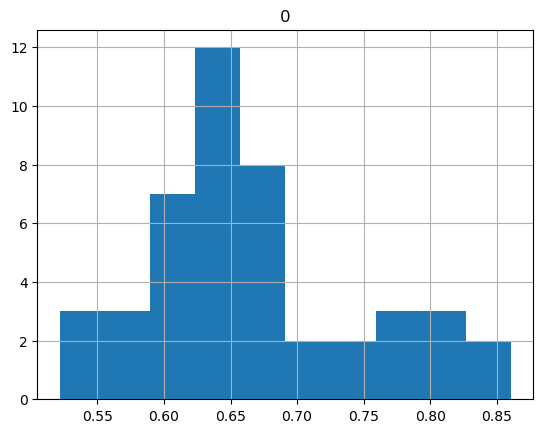

In [18]:

# Example: computing pairwise Cohen’s kappa
kappas = []
for i in range(len(score_columns)):
    for j in range(i+1, len(score_columns)):
        # Note the conversion to str (it gets confused with integers, and this is OK as they should be categories anyway really)
        kappa = cohen_kappa_score(
            df.loc[df.failed_predictions==0, score_columns[i]].astype(str),
            df.loc[df.failed_predictions==0, score_columns[j]].astype(str))
        #kappas.append((score_columns[i], score_columns[j], kappa))
        kappas.append(kappa)

# kappas now holds pairwise kappa scores
# You can check the distribution or mean of these kappas to gauge consistency
pd.DataFrame(kappas).hist()

Instead, use **Fleiss' Kappa** as this compares all ten 'annotaters' simultaneously (thanks ChatGPT)

[X] TODO: check and adapt code for this scenario

In [19]:
df_error_free = df.loc[df.failed_predictions==0]

# Table with just the scores
ratings = df_error_free[score_columns]

# Identify unique categories
categories = sorted(ratings.stack().unique())  # e.g., ['1', '2', '3', '4']
# Give the categories indices (0--4)
category_to_idx = {cat: i for i, cat in enumerate(categories)}

N = len(df_error_free)              # Number of items
k = len(categories)      # Number of categories

# Create a count matrix (N x k), where each cell is the count of how many raters assigned that category
# (So each row has a 5-element array which counts the number of raters giving eaach category (1--5)
count_matrix = np.zeros((N, k), dtype=int)

for i, row in enumerate(ratings.values):
    for val in row:
        col_idx = category_to_idx[val]
        count_matrix[i, col_idx] += 1

# Now use fleiss_kappa from statsmodels directly
kappa_value = fleiss_kappa(count_matrix)
print("Fleiss' Kappa:", kappa_value)


Fleiss' Kappa: 0.6646300486033372


Fleiss value of 0.66 suggests moderate agreement.

I'm fairly happy with the LLM output, it _might_ be suggestive of gentrification and appears to be fairly robust if you ask it the same question multiple times. Now I will move on to a different dataset, probably in another notebook.